In [1]:
from typing import Annotated
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Initialize models
llm = ChatOpenAI(model="gpt-4.1", temperature=0)
embeddings = OpenAIEmbeddings()

In [5]:
## Node Functionality
def chatbot7(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [7]:
graph_builder=StateGraph(State)
graph_builder.add_node("chatbot",chatbot7)
graph_builder.set_entry_point("chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph=graph_builder.compile()


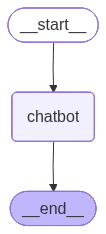

In [8]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
response=graph.invoke({"messages":"Hi"})


In [10]:
response["messages"][-1].content


'Hello! How can I help you today? 😊'

In [11]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


In [12]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [13]:
## Custom function
def multiply(a:int,b:int)->int:
    #Dot String for llm understanding
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [14]:
tools=[tool,multiply]

In [15]:

llm_with_tool=llm.bind_tools(tools)

In [16]:

llm_with_tool


RunnableBinding(bound=ChatOpenAI(profile={'max_input_tokens': 1047576, 'max_output_tokens': 32768, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x0000016C48430320>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000016C489A9190>, root_client=<openai.OpenAI object at 0x0000016C482F4BF0>, root_async_client=<openai.AsyncOpenAI object at 0x0000016C484C37D0>, model_name='gpt-4.1', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimi

In [17]:
llm_with_tool

RunnableBinding(bound=ChatOpenAI(profile={'max_input_tokens': 1047576, 'max_output_tokens': 32768, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x0000016C48430320>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000016C489A9190>, root_client=<openai.OpenAI object at 0x0000016C482F4BF0>, root_async_client=<openai.AsyncOpenAI object at 0x0000016C484C37D0>, model_name='gpt-4.1', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimi

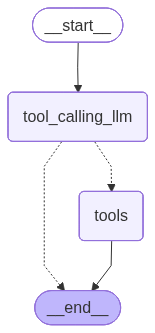

In [18]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
response=graph.invoke({"messages":"What is the recent ai news"})


In [20]:
response['messages'][-1].content


'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/ai-news-today-december-5-2025-gemini-3-deep-think-anthropics-agentic-ai-and-fresh-security-warnings/", "title": "AI News Today, December 5, 2025: Gemini 3 Deep Think, Anthropic’s Agentic AI, and Fresh Security Warnings - ts2.tech", "score": 0.8616433, "published_date": "Fri, 05 Dec 2025 11:15:01 GMT", "content": "Paired with travel‑planning bots, AI‑assisted medical workflows (such as recent work on anesthesiology decision support), and AI‑enhanced browsers, these developments show how AI is dissolving into the background of everyday digital services, even when it’s not in the headline.\\n\\n## 8. What today’s AI news means for you\\n\\nPutting all of these stories together, a few patterns stand out: [...] From Google’s new Gemini 3 Deep Think mode to Anthropic’s $200 million “agentic AI” deal with Snowflake, and new guidance from security agencies on how not

In [21]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_cYEhmRjOgZakLTOa2Ooa8WN1)
 Call ID: call_cYEhmRjOgZakLTOa2Ooa8WN1
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/ai-news-today-december-5-2025-gemini-3-deep-think-anthropics-agentic-ai-and-fresh-security-warnings/", "title": "AI News Today, December 5, 2025: Gemini 3 Deep Think, Anthropic’s Agentic AI, and Fresh Security Warnings - ts2.tech", "score": 0.8616433, "published_date": "Fri, 05 Dec 2025 11:15:01 GMT", "content": "Paired with travel‑planning bots, AI‑assisted medical workflows (su

In [22]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_iaSHbwSQDBYHwpDUM0Iam6py)
 Call ID: call_iaSHbwSQDBYHwpDUM0Iam6py
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [23]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_VErSC67LqyFxSxI6N3UP4R3q)
 Call ID: call_VErSC67LqyFxSxI6N3UP4R3q
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
  multiply (call_jlMrz4hi0f33YnWyioiWzRC7)
 Call ID: call_jlMrz4hi0f33YnWyioiWzRC7
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/ai-news-today-december-5-2025-gemini-3-deep-think-anthropics-agentic-ai-and-fresh-security-warnings/", "title": "AI News Today, December 5, 2025: Gemini 3 Deep Think, Anthropic’s Agentic AI, and Fresh Security Warnings - ts2.tech", "score": 0.99732697, "published_dat

ReAct Agent Architecture


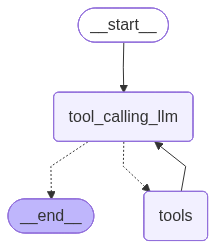

In [24]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_TUaLB5ngIJtvLFRVqE1gNUye)
 Call ID: call_TUaLB5ngIJtvLFRVqE1gNUye
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
  multiply (call_33DCWojveeOPlYerw1CMurLU)
 Call ID: call_33DCWojveeOPlYerw1CMurLU
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/ai-news-today-december-5-2025-gemini-3-deep-think-anthropics-agentic-ai-and-fresh-security-warnings/", "title": "AI News Today, December 5, 2025: Gemini 3 Deep Think, Anthropic’s Agentic AI, and Fresh Security Warnings - ts2.tech", "score": 0.8616433, "published_date

Adding Memory In Agentic Graph

In [26]:
response=graph.invoke({"messages":"Hello my name is Shees"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Shees
================================== Ai Message ==================================

Hello Shees! How can I assist you today?


In [27]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================

You haven’t told me your name yet. If you’d like, you can share your name and I’ll remember it for our conversation!


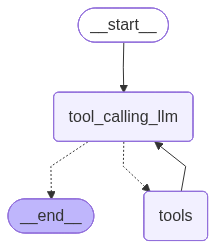

In [28]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Shees"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Shees', additional_kwargs={}, response_metadata={}, id='93d8d730-4eab-44a4-90f3-875cda6d5b0b'),
  AIMessage(content='Hello Shees! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 1303, 'total_tokens': 1315, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_433e8c8649', 'id': 'chatcmpl-CkQiy0JOIC8U9fCPxvdEtAtEsePsr', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--6175777c-d7ba-4163-b9d8-f64d659a14b3-0', usage_metadata={'input_tokens': 1303, 'output_tokens': 12, 'total_tokens': 1315, 'input_token_details': {'audio': 0, 'cache_read': 1280}, 'output_token_details': {'au

In [30]:
response['messages'][-1].content

'Hello Shees! How can I help you today?'

In [31]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Your name is Shees.


In [33]:
response=graph.invoke({"messages":"Hey do you remember mmy name"},config=config)

print(response['messages'][-1].content)

Yes, your name is Shees!


Streaming

In [34]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [35]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

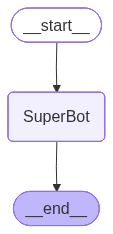

In [36]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [37]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Shees And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Shees And I like cricket', additional_kwargs={}, response_metadata={}, id='bc2da481-4fc7-4441-99d4-7b6c5beda949'),
  AIMessage(content='Hi Shees! 👋 That’s awesome—you like cricket! 🏏 Who’s your favorite cricketer or team? Do you play cricket yourself, or do you enjoy watching matches more?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 18, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_433e8c8649', 'id': 'chatcmpl-CkQkRpOLeGSLo11sPvEP62vzEMvk6', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--3f1f7396-eebf-44d7-87d4-3bc97b51d653-0', usage_metadata={'input_tokens': 18, 'o

Streaming
Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

values : This streams the full state of the graph after each node is called.
updates : This streams updates to the state of the graph after each node is called.

In [38]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hi Krish! Nice to meet you. That’s awesome that you like cricket! Who’s your favorite cricketer or team? Do you play cricket yourself, or do you enjoy watching matches more?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 18, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_09249d7c7b', 'id': 'chatcmpl-CkQkkA01kJpHYNkd0fcPO0FjhVdKE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--895f6ea8-6441-4c5e-9532-edaa9ab995f0-0', usage_metadata={'input_tokens': 18, 'output_tokens': 41, 'total_tokens': 59, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'au

In [40]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='d5e6bec3-556f-4d81-b241-cf7f83927499'), AIMessage(content='Hi Krish! Nice to meet you. That’s awesome that you like cricket! Who’s your favorite cricketer or team? Do you play cricket yourself, or do you enjoy watching matches more?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 18, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_09249d7c7b', 'id': 'chatcmpl-CkQkkA01kJpHYNkd0fcPO0FjhVdKE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--895f6ea8-6441-4c5e-9532-edaa9ab995f0-0', usage_metadata={'inpu

In [41]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hi Krish! It’s great to meet you. Cricket is an awesome sport—do you play, or do you enjoy watching it more? Who’s your favorite team or player?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 18, 'total_tokens': 55, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_433e8c8649', 'id': 'chatcmpl-CkQl3mWMTRHo5rNWMW3weSc7gvMpL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--d203cd89-31d9-4b9d-b0d5-25ac6d9cc90a-0', usage_metadata={'input_tokens': 18, 'output_tokens': 37, 'total_tokens': 55, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

In [42]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='9a26c103-534d-4ffb-b976-ca0d1068a8bc'), AIMessage(content='Hi Krish! It’s great to meet you. Cricket is an awesome sport—do you play, or do you enjoy watching it more? Who’s your favorite team or player?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 18, 'total_tokens': 55, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_433e8c8649', 'id': 'chatcmpl-CkQl3mWMTRHo5rNWMW3weSc7gvMpL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--d203cd89-31d9-4b9d-b0d5-25ac6d9cc90a-0', usage_metadata={'input_tokens': 18, 'output_tokens

In [43]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '1fd8ec09-79fb-4fef-910b-a55d934a0998', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='2bb03fef-e345-4248-bed7-7ae146507624')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '1d33757d-4406-4071-bfa9-80d570a2fe27', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:7f6e487b-ee1c-689e-1ec6-f15202be583d'}, 'parent_ids': ['1fd8ec09-79fb-4fef-910b-a55d934a0998']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla